# Example signal simulation, combination and segmentation

This Notebook we go through:

- how to construct
  - the 21cm,
  - galactic foreground and
  - synchroton signals
- how to combine the signals
- apply the segmentation


In [39]:
from pathlib import Path
import threading

from astropy.coordinates import Angle, SkyCoord
from astropy import units
import pandas as pd

from karabo.simulation.signal.typing import BaseImage, Image2D
from karabo.simulation.signal.plotting import SignalPlotting, SegmentationPlotting
from karabo.simulation.signal.signal_21_cm import Signal21cm
from karabo.simulation.signal.synchroton_signal import SignalSynchroton
from karabo.simulation.signal.galactic_foreground import SignalGalacticForeground
from karabo.simulation.signal.superimpose import Superimpose
from karabo.simulation.signal.superpixel_segmentation import SuperpixelSegmentation
from karabo.simulation.signal.seg_u_net_segmentation import SegUNetSegmentation


In [3]:
print(redshifts_gf := SignalGalacticForeground.available_redshifts())
print("- " * 3)
print(redshifts_21 := Signal21cm.available_redshifts())


[7.6, 8.4, 9.2, 9.9, 10.7, 11.5, 12.2, 13.0, 14.3, 15.1, 15.8, 16.6, 17.4, 18.1, 18.9, 19.7, 20.4, 21.2, 22.0, 22.7]
- - - 
[6.0, 6.056, 6.113, 6.172, 6.231, 6.292, 6.354, 6.418, 6.483, 6.549, 6.617, 6.686, 6.757, 6.83, 6.905, 6.981, 7.059, 7.139, 7.221, 7.305, 7.391, 7.48, 7.57, 7.664, 7.76, 7.859, 7.96, 8.064, 8.172, 8.283, 8.397, 8.515, 8.636, 8.762, 8.892, 9.026, 9.164, 9.308, 9.457, 9.611, 9.771, 9.938, 10.11, 10.29, 10.478, 10.673, 10.877, 11.09, 11.313, 11.546, 11.791, 12.048, 12.318, 12.603, 12.903, 13.221, 13.557, 13.914, 14.294, 14.699, 15.132, 15.596, 16.095, 16.633, 17.215, 17.848, 18.54, 19.298, 20.134]


In [44]:
short_l = redshifts_gf
long_l = redshifts_21
labels = ("Galactic foreground", "21cm")

if len(short_l) > len(long_l):
    short_l, long_l = (long_l, short_l)
    labels = (labels[1], labels[0])

nums = [(0, 0, float("inf"))] * len(short_l)
for i, num1 in enumerate(short_l):
    for num2 in long_l:
        diff = abs(num2 - num1)
        if diff < nums[i][2]:
            nums[i] = (num1, num2, diff)

nums = sorted(nums, key=lambda x: x[2], reverse=False)

print("Best matches")
pd.DataFrame(nums, columns=(*labels, "Difference"))


Best matches


Galactic foreground    21cm  Difference
0                   8.4   8.397       0.003
1                  14.3  14.294       0.006
2                  10.7  10.673       0.027
3                   7.6   7.570       0.030
4                  15.1  15.132       0.032
5                  16.6  16.633       0.033
6                   9.2   9.164       0.036
7                   9.9   9.938       0.038
8                  11.5  11.546       0.046
9                  13.0  12.903       0.097
10                 12.2  12.318       0.118
11                 17.4  17.215       0.185
12                 15.8  15.596       0.204
13                 18.1  17.848       0.252
14                 20.4  20.134       0.266
15                 18.9  18.540       0.360
16                 19.7  19.298       0.402
17                 21.2  20.134       1.066
18                 22.0  20.134       1.866
19                 22.7  20.134       2.566

**7.6** lower:7.57 (0.03) higher:7.664 (0.064)  
**8.4** lower:8.397 (0.003) higher:8.515 (0.115)  
**9.2** lower:9.164 (0.036) higher:9.308 (0.108)  
**9.9** lower:9.771 (0.129) higher:9.938 (0.038)

**10.7** lower:10.673 (0.027) higher:10.877 (0.177)  
**11.5** lower:11.313 (0.187) higher:11.546 (0.046)  
**12.2** lower:12.048 (0.152) higher:12.318 (0.118)  
**13.0** lower:12.903 (0.097) higher:13.221 (0.221)

**14.3** lower:14.294 (0.006) higher:14.699 (0.399)  
**15.1** lower:14.699 (0.401) higher:15.132 (0.032)  
**15.8** lower:15.596 (0.204) higher:16.095 (0.295)  
**16.6** lower:16.095 (0.505) higher:16.633 (0.033)

**17.4** lower:17.215 (0.185) higher:17.848 (0.448)  
**18.1** lower:17.848 (0.252) higher:18.54 (0.44)  
**18.9** lower:18.54 (0.36) higher:19.298 (0.398)  
**19.7** lower:19.298 (0.402) higher:20.134 (0.434)

**20.4** lower:20.134 (0.266) higher: -  
**21.2** lower: - higher: -  
**22.0** lower: - higher: -  
**22** lower: - higher: -


**7.6** lower:7.57 (0.03)  
**8.4 lower:8.397 (0.003)**  
**9.2** lower:9.164 (0.036)  
**9.9** higher:9.938 (0.038)

**10.7 lower:10.673 (0.027)**  
**11.5** higher:11.546 (0.046)  
**13.0** lower:12.903 (0.097)

**14.3 lower:14.294 (0.006)**  
**15.1** higher:15.132 (0.032)  
**16.6** higher:16.633 (0.033)

**17.4 lower:17.215 (0.185)**  
**18.1** lower:17.848 (0.252)  
**18.9** lower:18.54 (0.36)

**20.4 lower:20.134 (0.266)**


In [15]:
# (Galactic, Signal21)
redshift_sig21 = [
    8.397,
    10.673,
    14.294,
    17.215,
    20.134,
]
redshift_gf = [
    8.4,
    10.7,
    14.3,
    17.4,
    20.4,
]


In [16]:
# TODO from internet
class ThreadWithReturnValue(threading.Thread):
    def __init__(
        self, group=None, target=None, name=None, args=(), kwargs={}, Verbose=None
    ):
        threading.Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args, **self._kwargs)

    def join(self, *args):
        threading.Thread.join(self, *args)
        return self._return


Running 21cm
Done simulating
Done combining, on to the Segmentation


100%|██████████| 250/250 [00:00<00:00, 400.02it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6521.47it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 62.26it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6018.28it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 437.06it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.37s/it]


Segmentation 1/5 done


100%|██████████| 250/250 [00:00<00:00, 421.94it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6028.25it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 62.95it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6301.19it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 445.44it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:31<00:00, 31.72s/it]


Segmentation 2/5 done


100%|██████████| 250/250 [00:00<00:00, 434.03it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6412.68it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 62.26it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5972.53it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 449.47it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:31<00:00, 31.46s/it]


Segmentation 3/5 done


100%|██████████| 250/250 [00:00<00:00, 447.74it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6367.84it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 63.98it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6161.59it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 450.65it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.29s/it]


Segmentation 4/5 done


100%|██████████| 250/250 [00:00<00:00, 448.76it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6179.53it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 63.31it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6432.66it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 444.77it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.73s/it]


Segmentation 5/5 done
Running 21cm
Running synchroton
Running Galactic foreground
Done simulating
Done combining, on to the Segmentation


100%|██████████| 250/250 [00:00<00:00, 441.03it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5418.49it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:02<00:00, 50.56it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5627.93it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 436.96it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:31<00:00, 31.14s/it]


Segmentation 1/5 done


100%|██████████| 250/250 [00:00<00:00, 440.36it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6161.66it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:01<00:00, 63.62it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 6760.70it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 430.11it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.18s/it]


Segmentation 2/5 done


100%|██████████| 250/250 [00:00<00:00, 432.90it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5315.43it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:02<00:00, 50.71it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5384.33it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 439.17it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:31<00:00, 31.38s/it]


Segmentation 3/5 done


100%|██████████| 250/250 [00:00<00:00, 444.10it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 4649.30it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:02<00:00, 47.43it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5652.39it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 450.71it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.47s/it]


Segmentation 4/5 done


100%|██████████| 250/250 [00:00<00:00, 452.75it/s]


Estimating superpixel labels using SLIC...
The output contains the labels with 124 segments
Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 5092.42it/s]


...done
Constructing the superpixel map...


100%|██████████| 124/124 [00:02<00:00, 46.71it/s]


Estimating the superpixel mean map...


100%|██████████| 124/124 [00:00<00:00, 2945.50it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 428.26it/s]


 Loaded model: /home/claire/miniconda3/envs/karabo-env/lib/python3.9/site-packages/tools21cm/input_data/segunet_02-10T23-52-36_128slice_ep56.h5


100%|██████████| 1/1 [00:30<00:00, 30.40s/it]


Segmentation 5/5 done


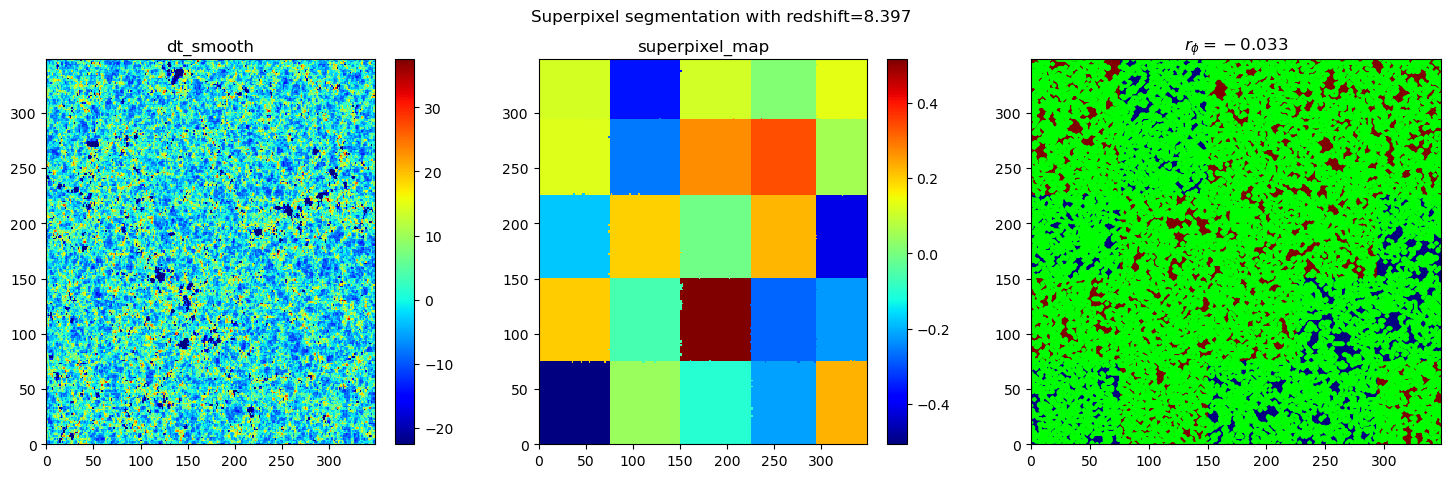

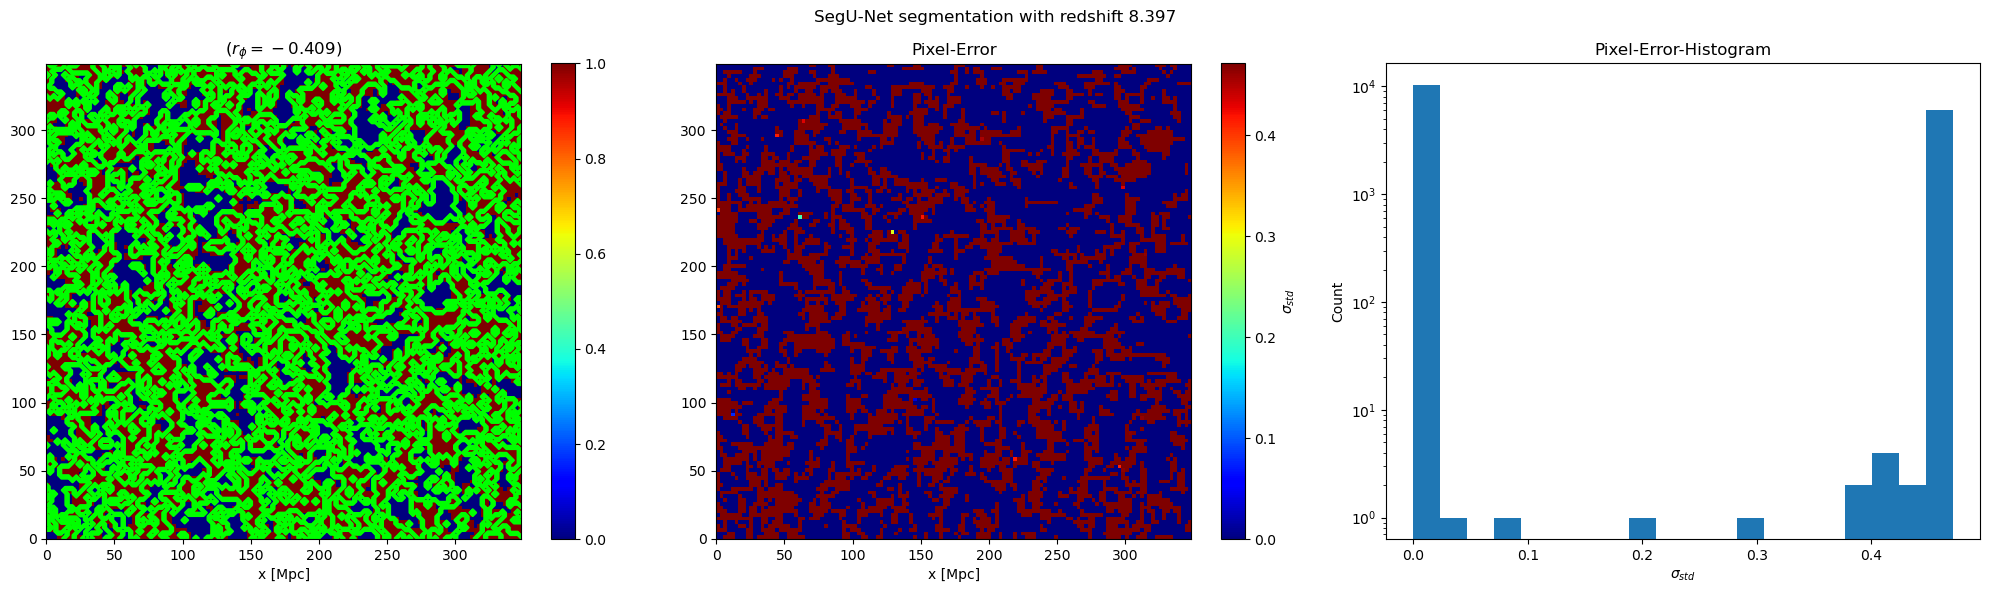

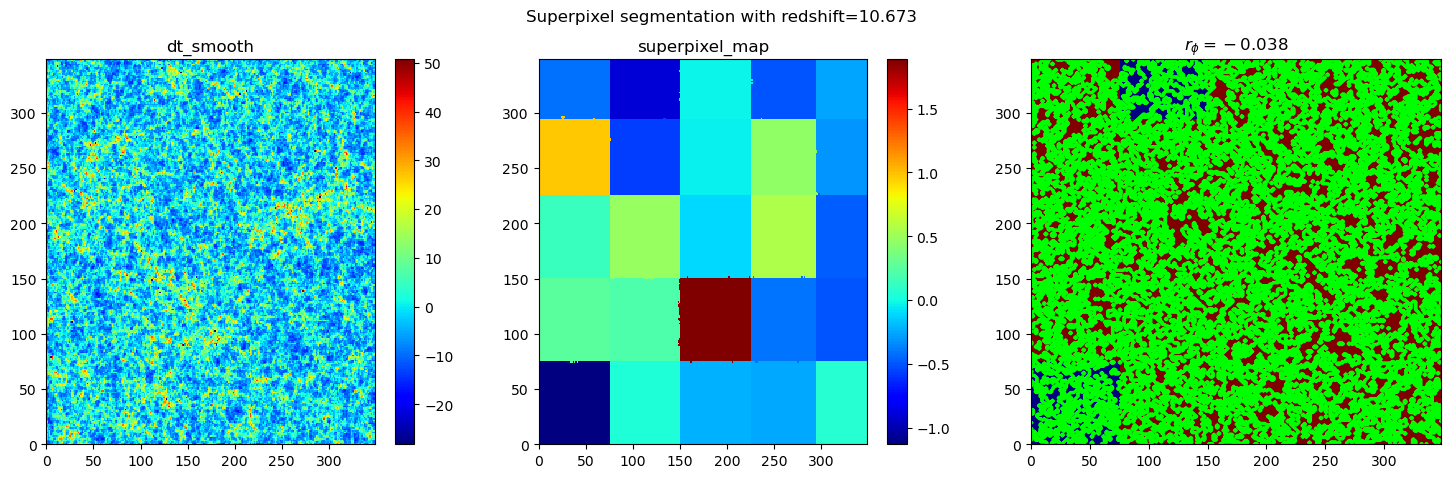

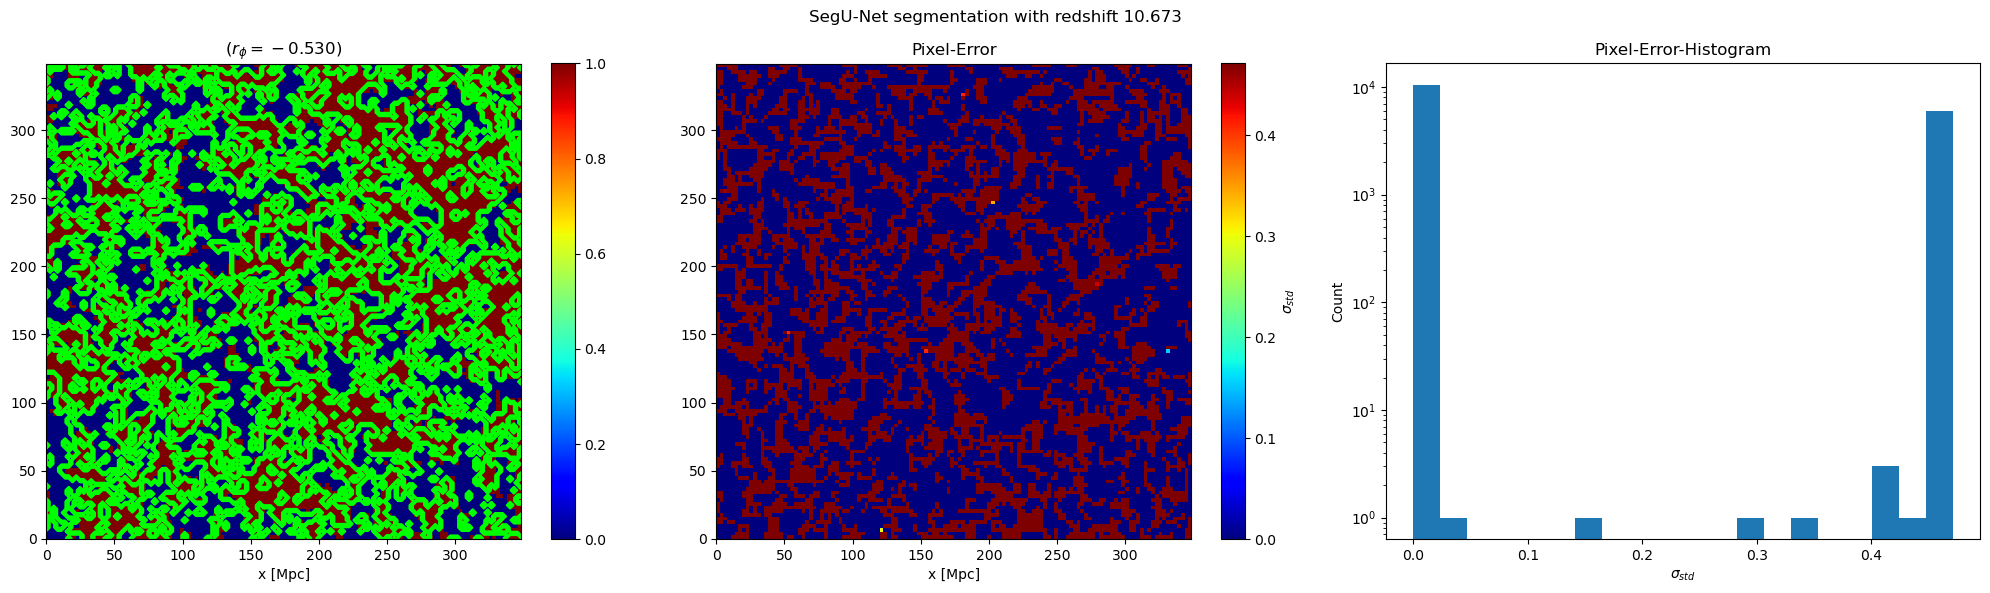

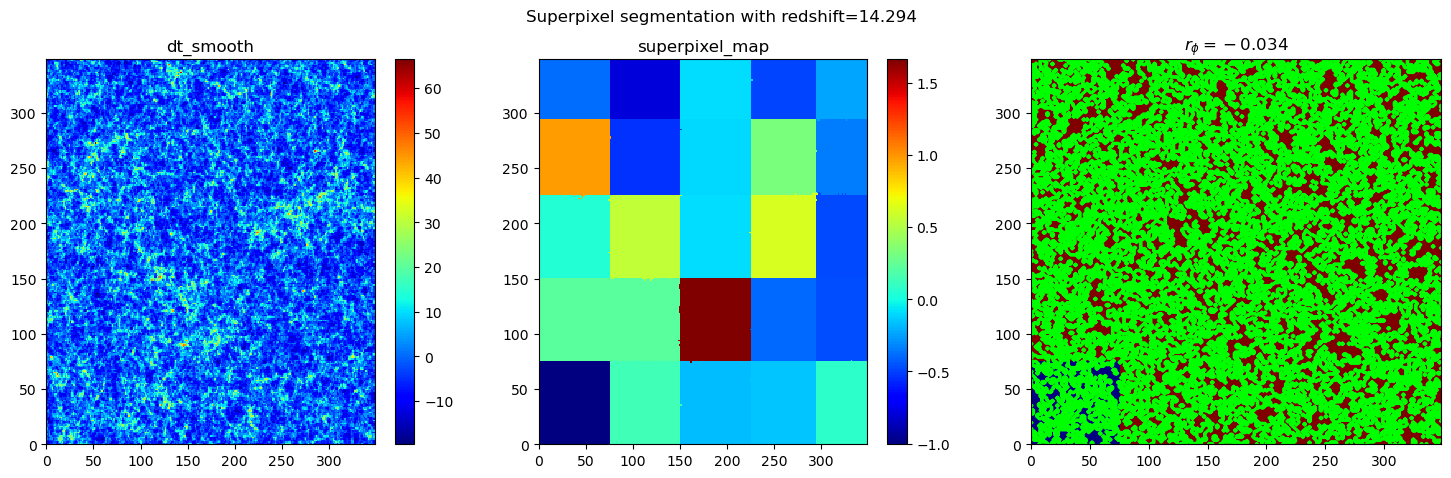

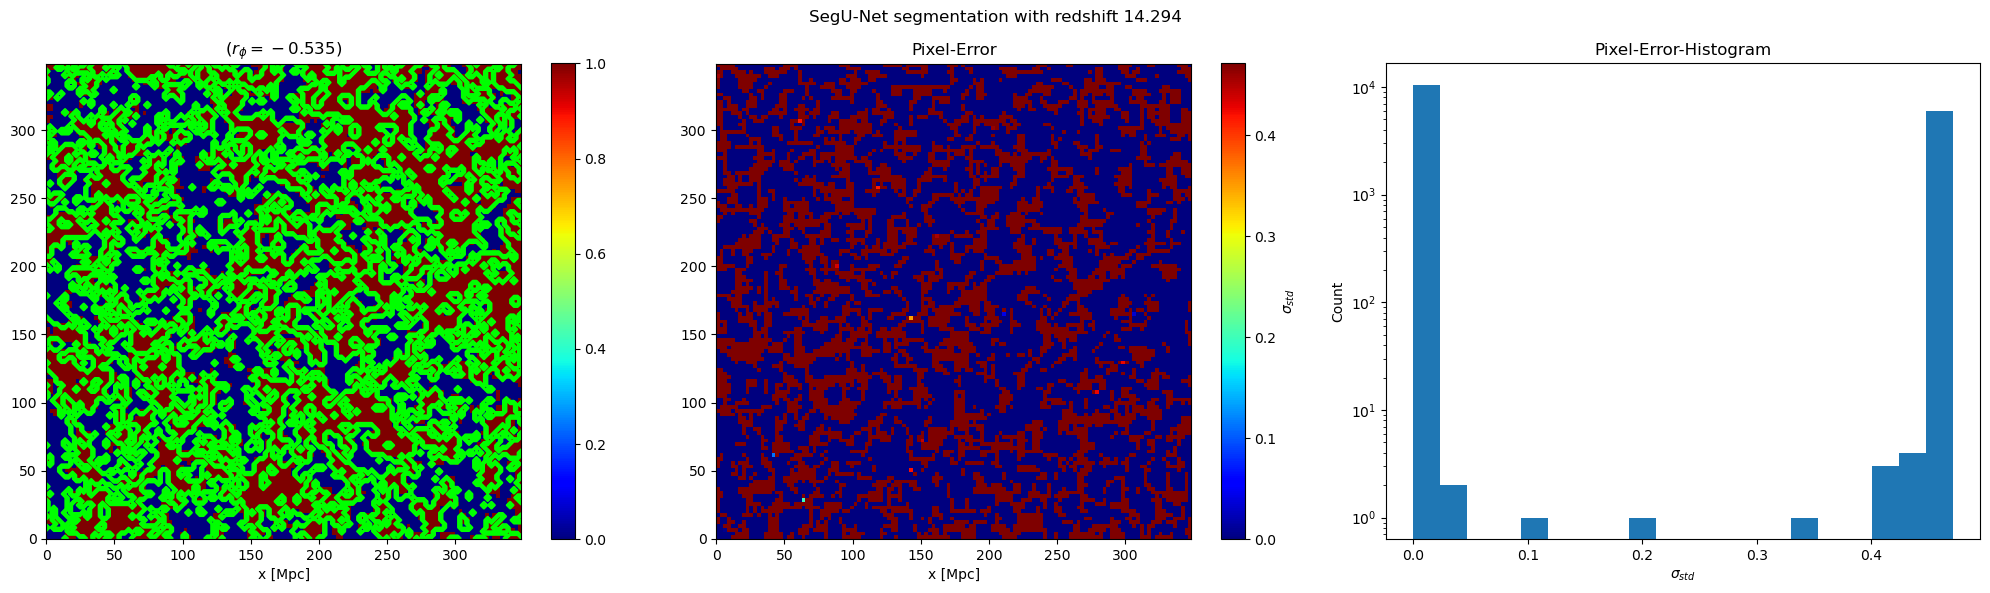

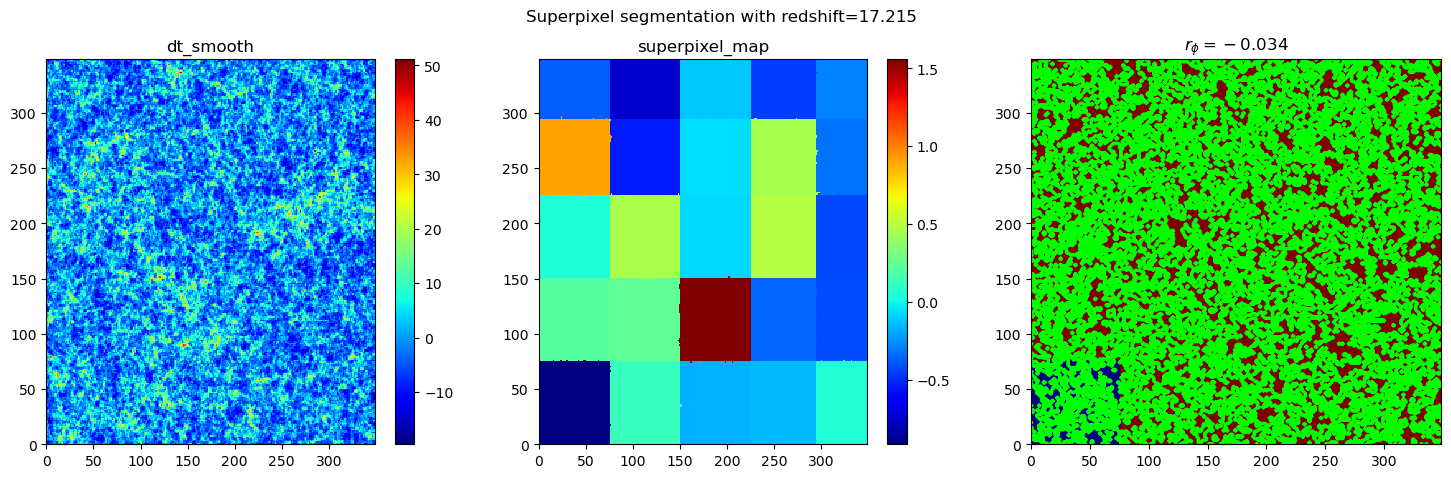

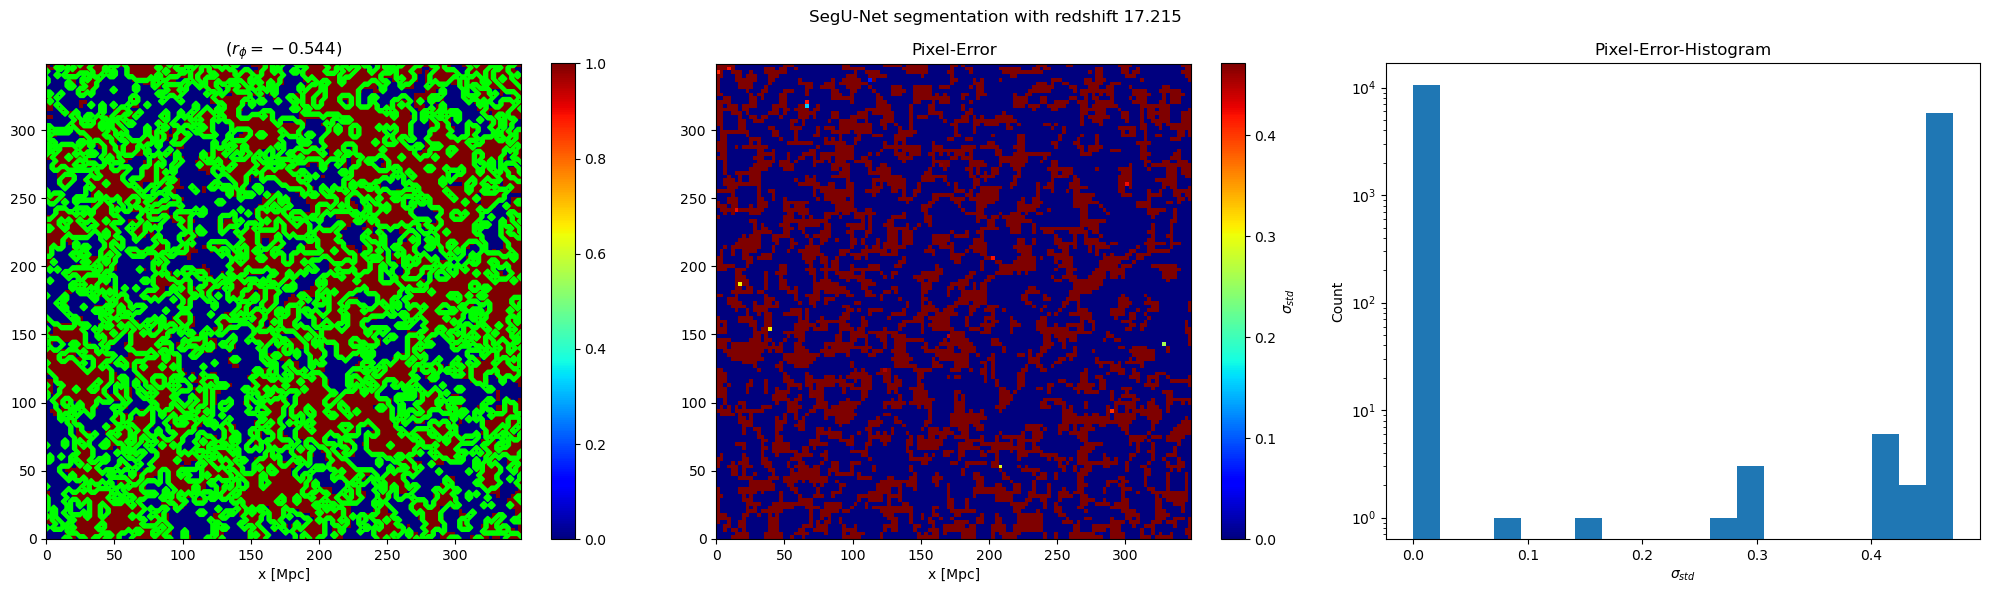

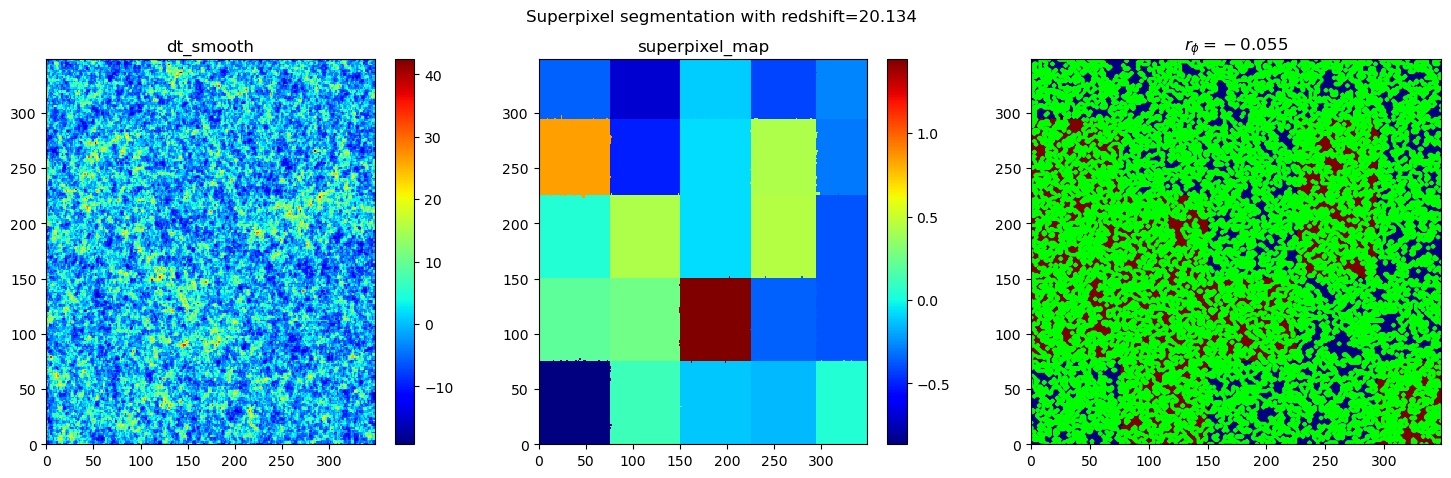

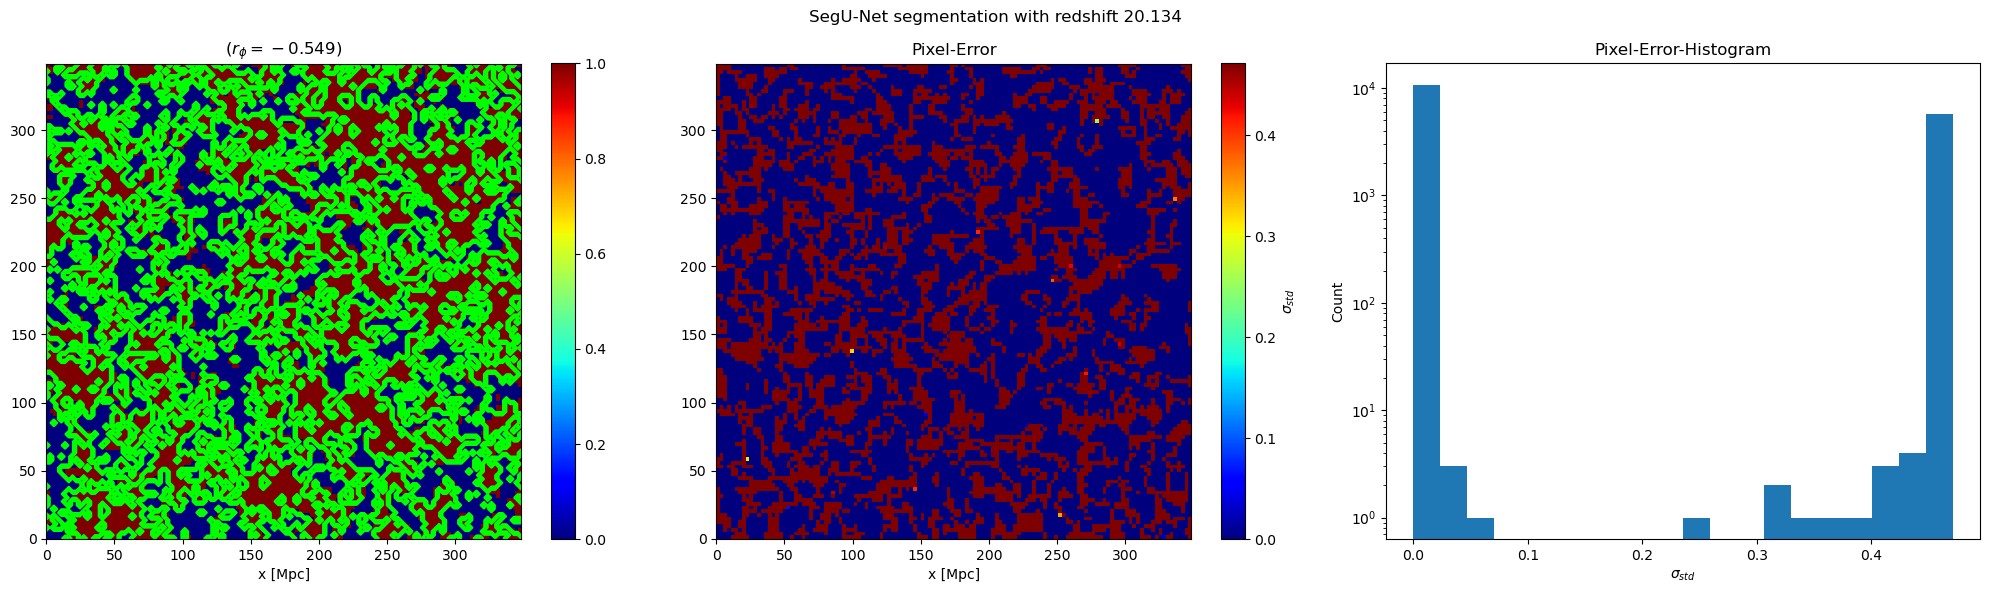

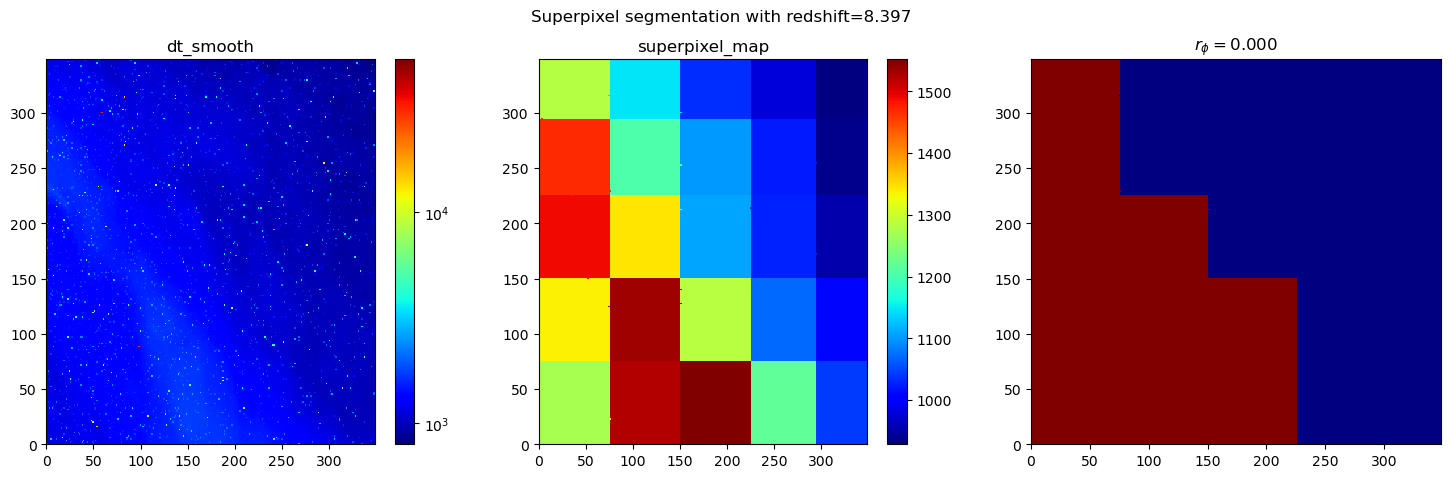

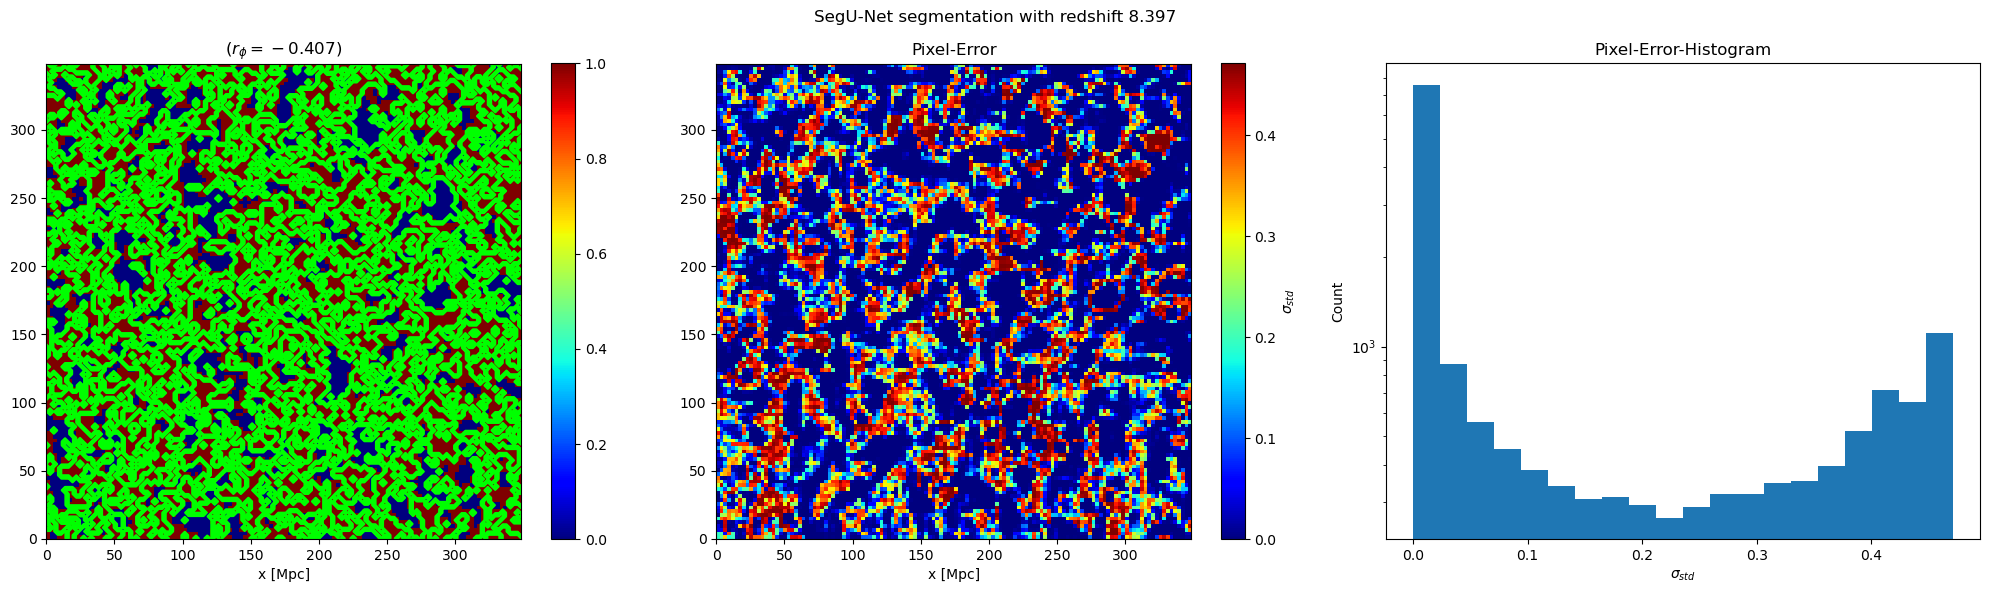

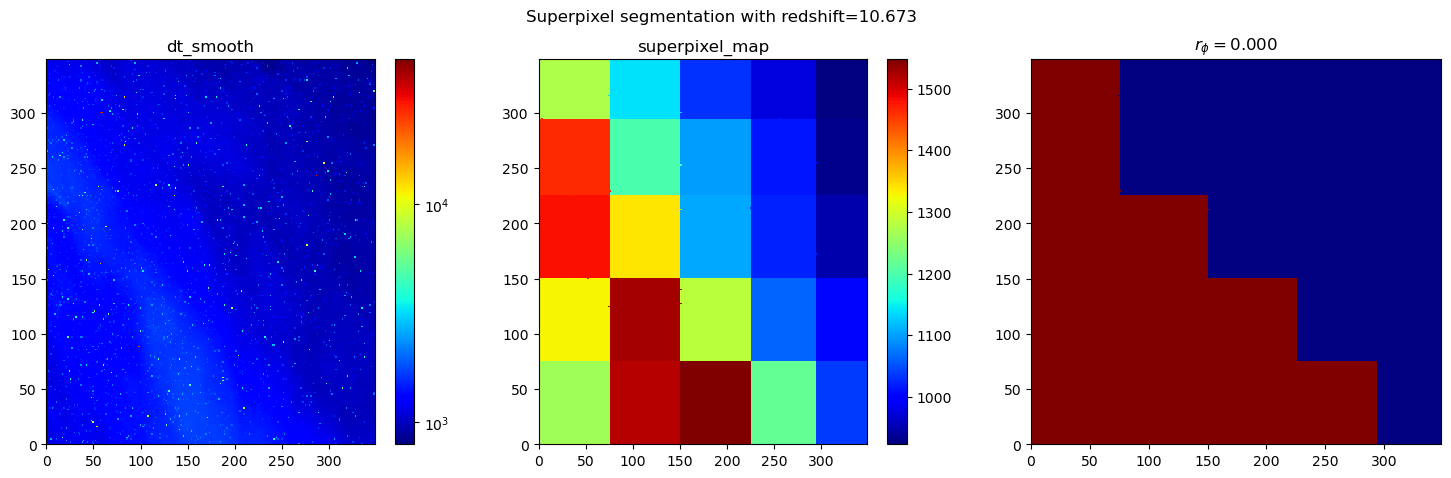

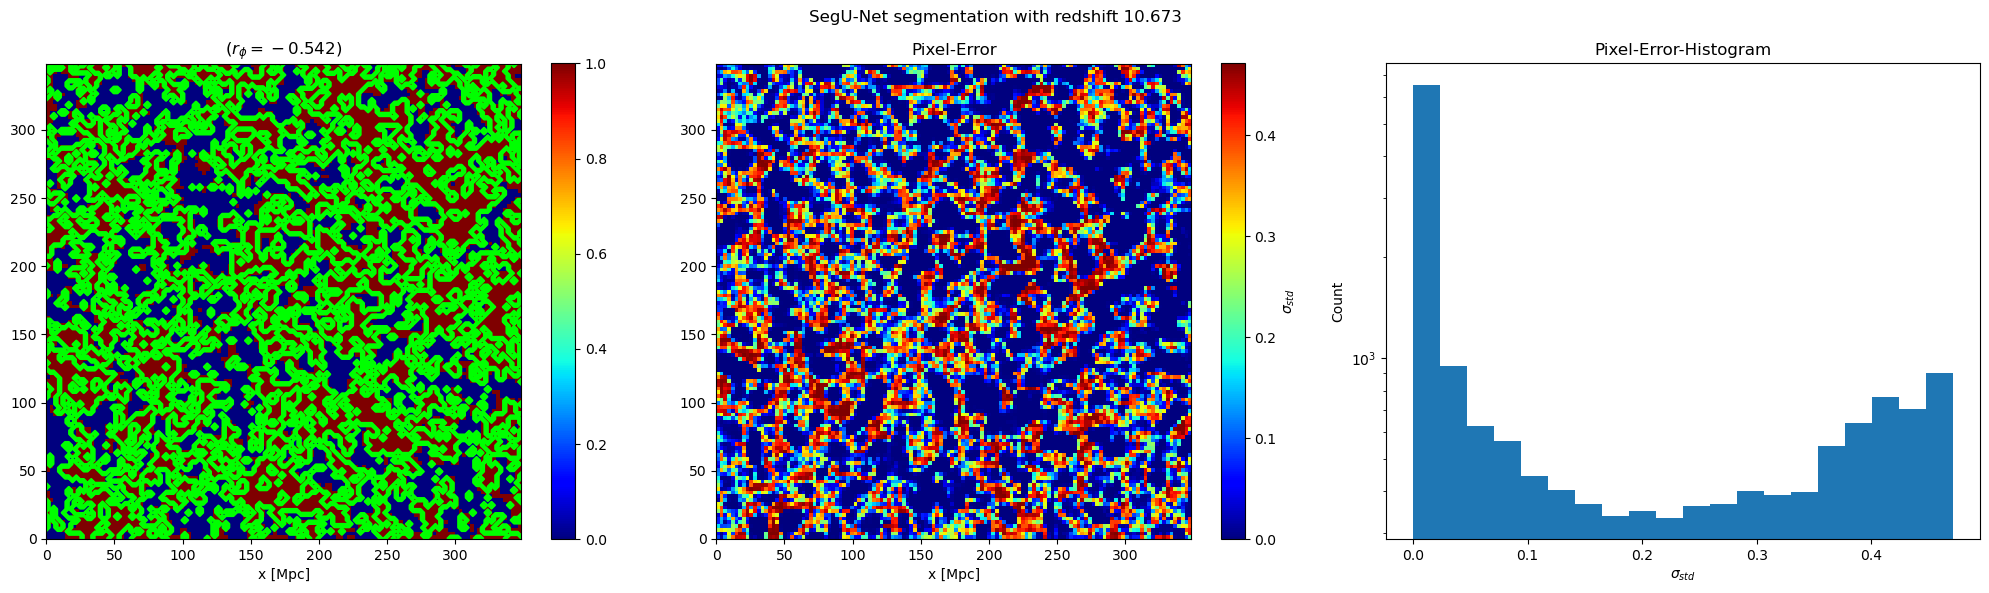

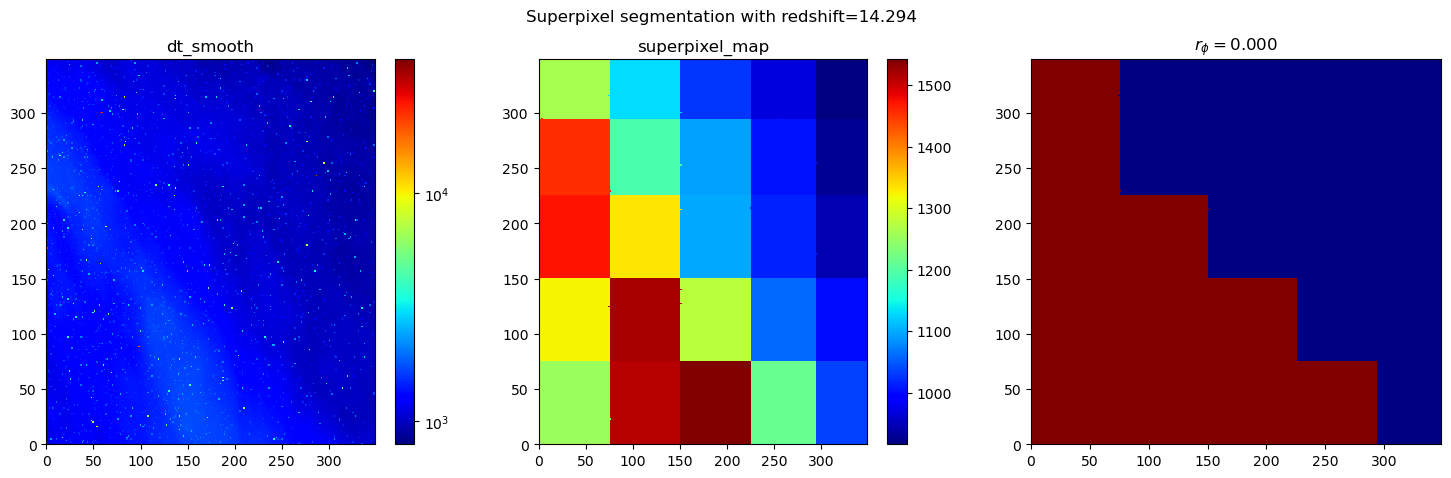

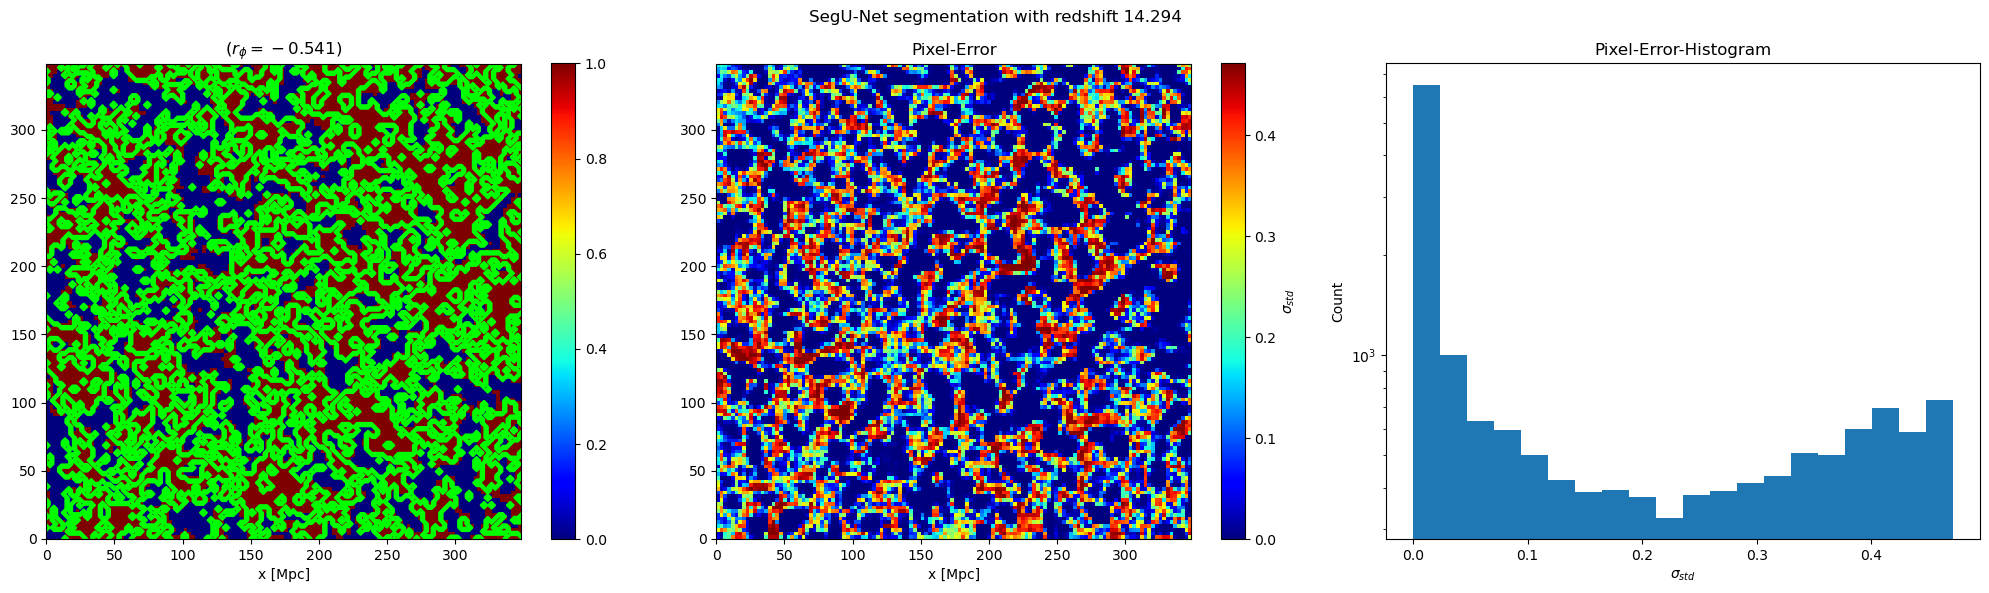

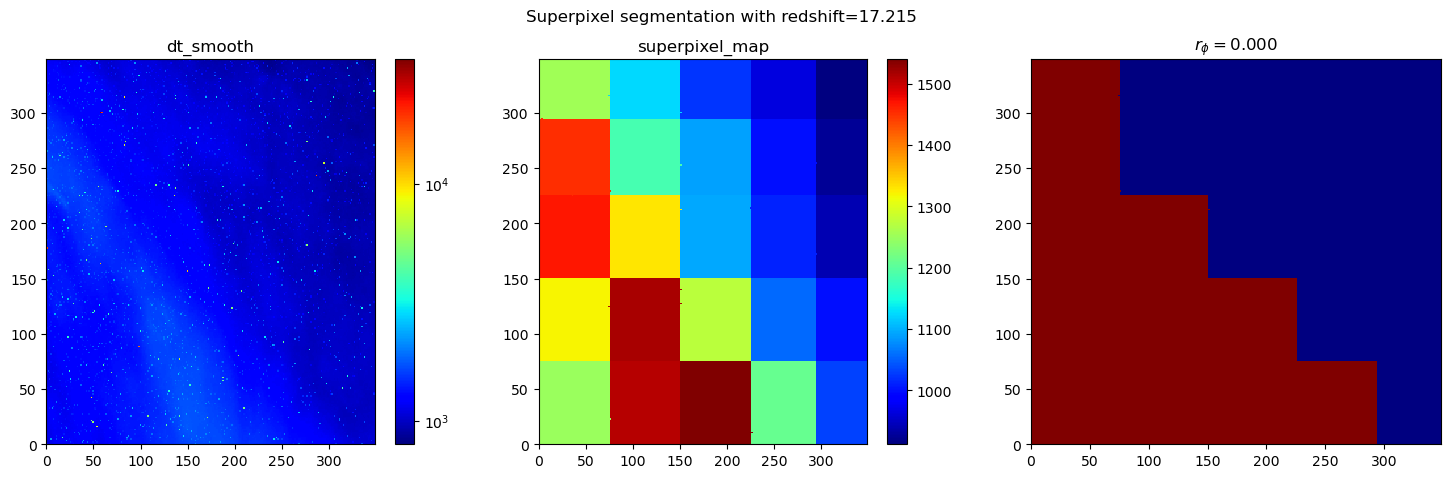

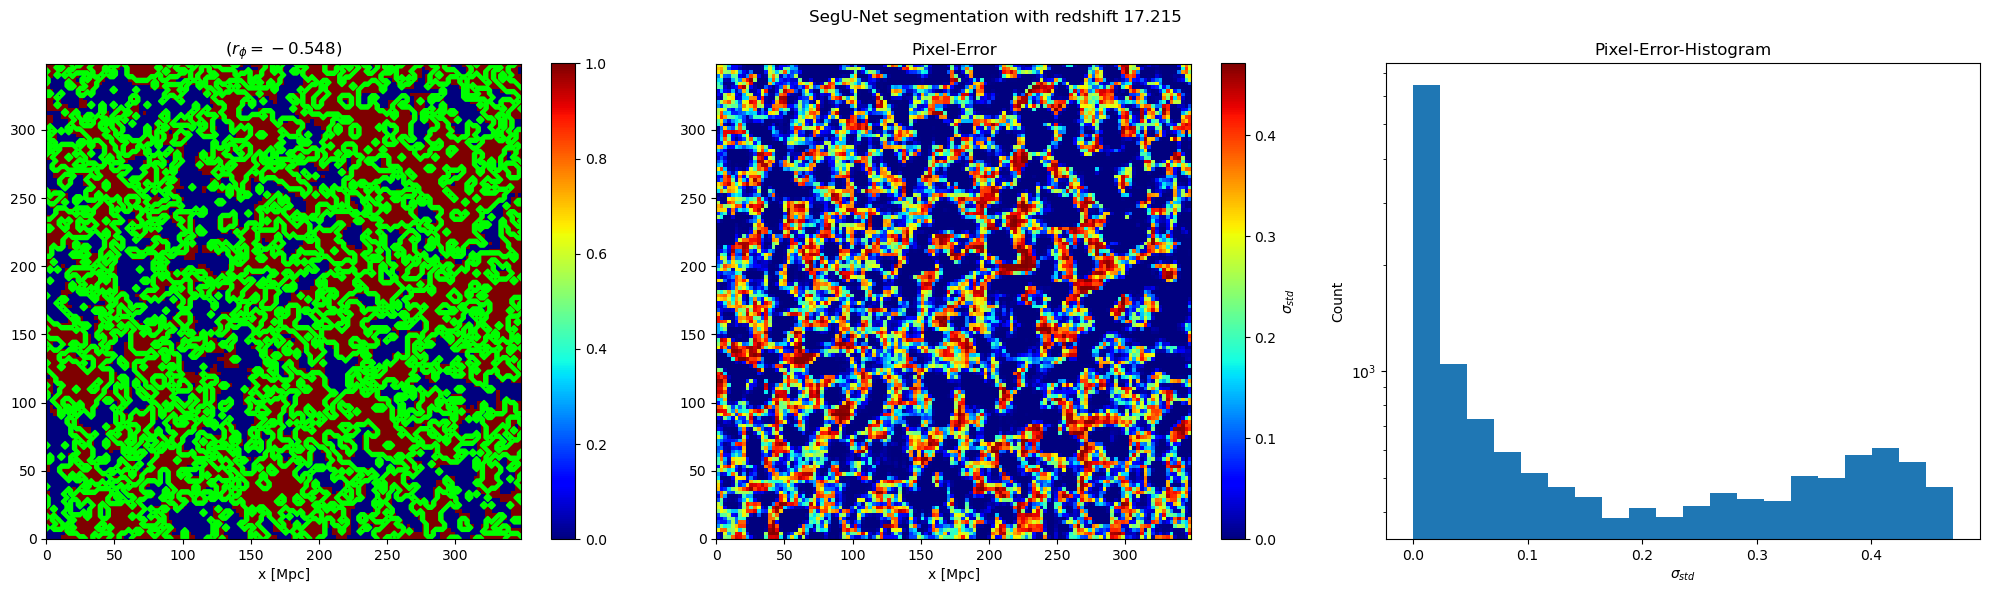

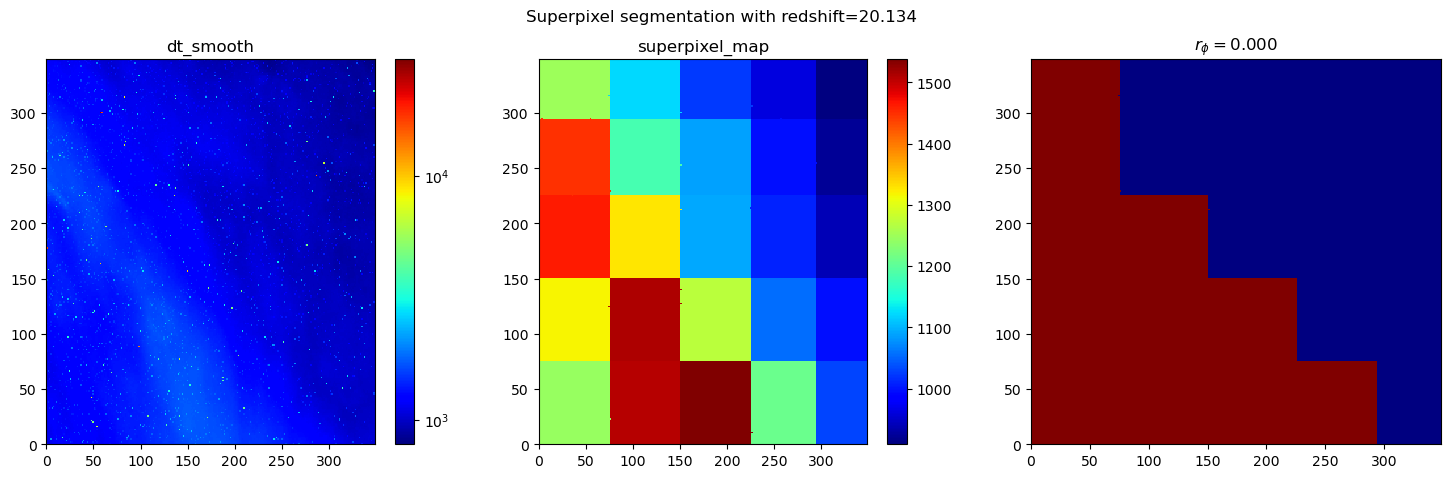

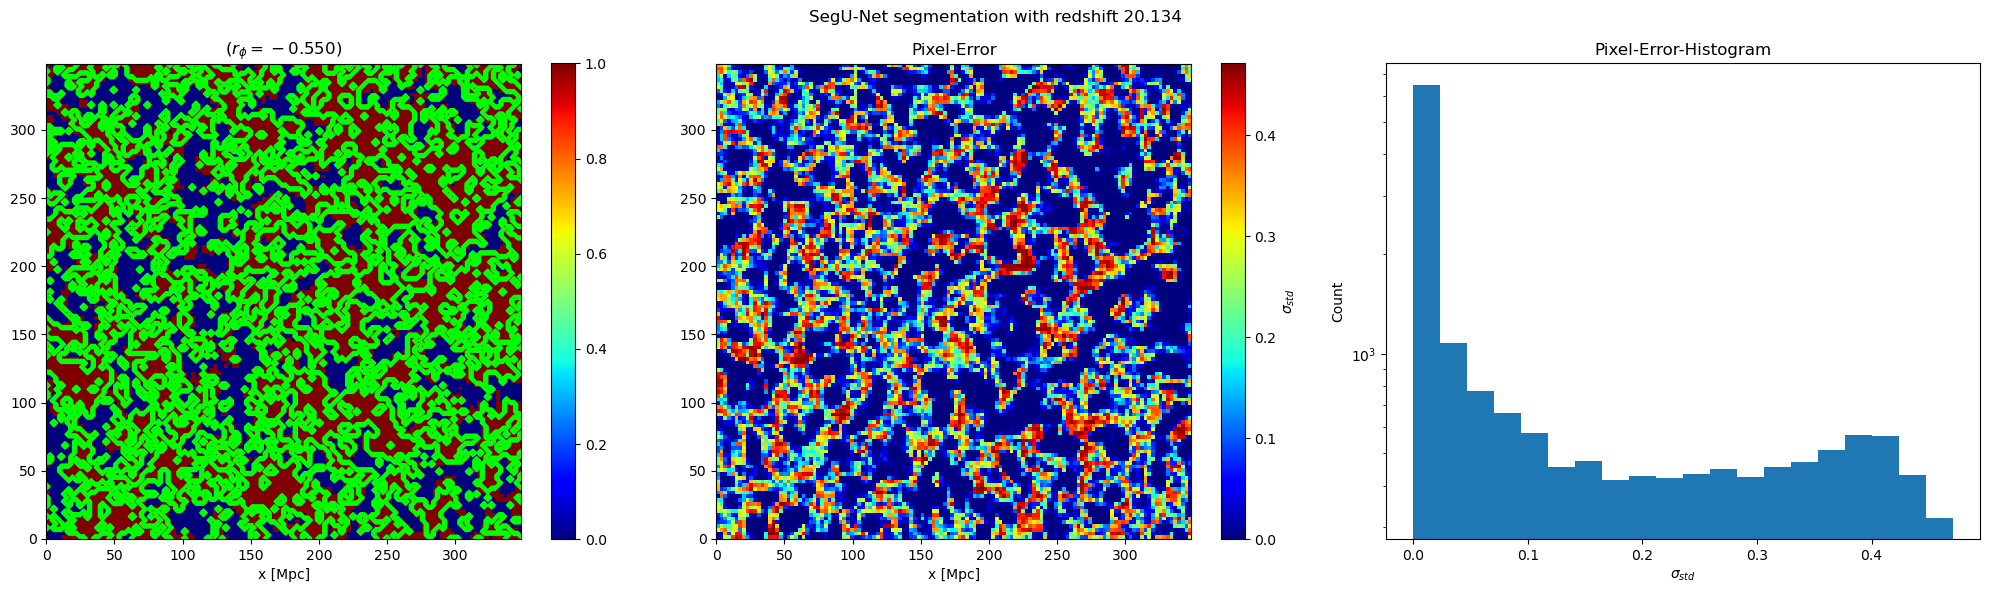

In [22]:
class ParallelZPipeline:
    def __init__(
        self,
        redshifts_sig21: list[float],
        redshifts_galactic: list[float],
        max_baseline: float = 70.0,
        n_segments: int = 1000,
        max_iter: int = 10,
        tta: int = 1,
        only_21cm: bool = True,
    ) -> None:
        self.only_21cm = only_21cm
        self.redshifts_sig21 = redshifts_sig21
        self.redshifts_galactic = redshifts_galactic

        # prepare signal21cm
        files_sig21 = [
            Signal21cm.get_xfrac_dens_file(z=z, box_dims=244 / 0.7)
            for z in redshifts_sig21
        ]
        self.signal_21 = Signal21cm(files_sig21)
        grid_size = (250, 250)

        if not only_21cm:
            # prepare galactic foreground
            cent = SkyCoord(ra=10 * units.degree, dec=20 * units.degree, frame="icrs")
            fov = Angle([20, 20], unit=units.degree)
            self.gf = SignalGalacticForeground(
                cent,
                redshifts=redshifts_galactic,
                fov=fov,
                grid_size=grid_size,
            )

            # prepare synchroton
            self.sync = SignalSynchroton(
                centre=cent,
                fov=fov,
                grid_size=grid_size,
            )

        self.max_baseline = max_baseline
        self.n_segments = n_segments
        self.max_iter = max_iter
        self.tta = tta

    def run(self) -> list[BaseImage]:
        sig_21cm_thread = ThreadWithReturnValue(target=self._simulate_signal_21cm)

        if not self.only_21cm:
            sig_sync_thread = ThreadWithReturnValue(target=self._simulate_syncroton)
            sig_gf_thread = ThreadWithReturnValue(
                target=self._simulate_galactic_foreground
            )

        sig_21cm_thread.start()

        if not self.only_21cm:
            sig_sync_thread.start()
            sig_gf_thread.start()

        images_sig21 = sig_21cm_thread.join()

        if not self.only_21cm:
            image_sync = sig_sync_thread.join()[0]
            images_galactic = sig_gf_thread.join()

        print("Done simulating")

        images: list[BaseImage] = []
        if self.only_21cm:
            images = images_sig21

        else:
            for im_21, im_gal in zip(images_sig21, images_galactic):
                image = Superimpose.combine(im_21, im_gal, image_sync)
                images.append(image)

        print("Done combining, on to the Segmentation")

        res = []
        idx = 0
        only_21cm_name = "_21cm_only" if self.only_21cm else ""
        for image, sig_21 in zip(images, images_sig21):
            superpixel_image = SuperpixelSegmentation(
                max_baseline=self.max_baseline,
                max_iter=self.max_iter,
                n_segments=self.n_segments,
            ).segment(image)
            superpixel_plot = SegmentationPlotting.superpixel_plotting(
                superpixel_image, sig_21, log_sky=not self.only_21cm
            )
            plot_path = Path("./karabo/simulation/signal/plots/")
            file_name = (
                f"_plot_z_{image.redshift}_baseline_{self.max_baseline}{only_21cm_name}"
            )
            superpixel_plot.savefig(plot_path / f"superpixel{file_name}.png")

            seg_u_net_image = SegUNetSegmentation(
                max_baseline=self.max_baseline,
                tta=self.tta,
            ).segment(sig_21)
            seg_u_net_plot = SegmentationPlotting.seg_u_net_plotting(seg_u_net_image)
            seg_u_net_plot.savefig(plot_path / f"seg_u_net{file_name}.png")

            res.append((superpixel_image, seg_u_net_image))
            idx += 1
            print(f"Segmentation {idx}/{len(images)} done")
        return res

    def _simulate_syncroton(self) -> Image2D:
        print("Running synchroton")
        return self.sync.simulate()

    def _simulate_signal_21cm(self) -> Image2D:
        print("Running 21cm")
        return self.signal_21.simulate()

    def _simulate_galactic_foreground(self) -> Image2D:
        print("Running Galactic foreground")
        return self.gf.simulate()


images_21 = ParallelZPipeline(
    redshifts_sig21=redshift_sig21,
    redshifts_galactic=redshift_gf,
    max_baseline=70.0,
    n_segments=100,
    max_iter=2,
    tta=1,
    only_21cm=True,
).run()
images_combined = ParallelZPipeline(
    redshifts_sig21=redshift_sig21,
    redshifts_galactic=redshift_gf,
    max_baseline=70.0,
    n_segments=100,
    max_iter=2,
    tta=1,
    only_21cm=False,
).run()


In [ ]:
%load_ext autoreload
%autoreload 2

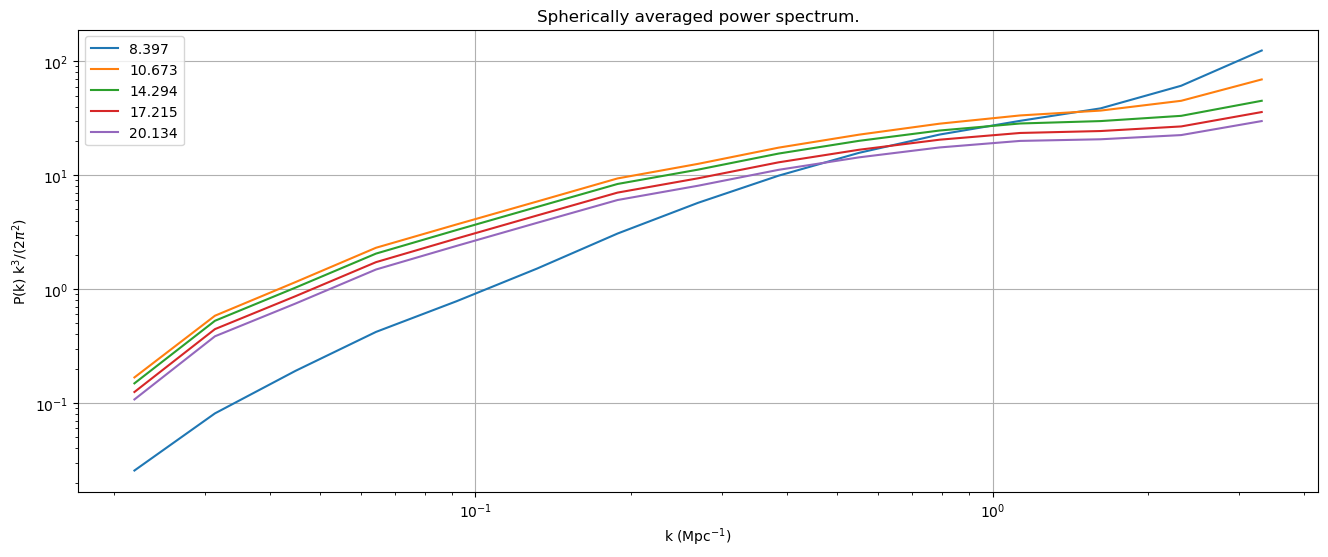

In [24]:
xfrac_dens_files = []
for z in redshift_sig21:
    xfrac_dens_files.append(Signal21cm.get_xfrac_dens_file(z=z, box_dims=244 / 0.7))

_ = SignalPlotting.power_spectrum_xfrac_dens(xfrac_dens_files)


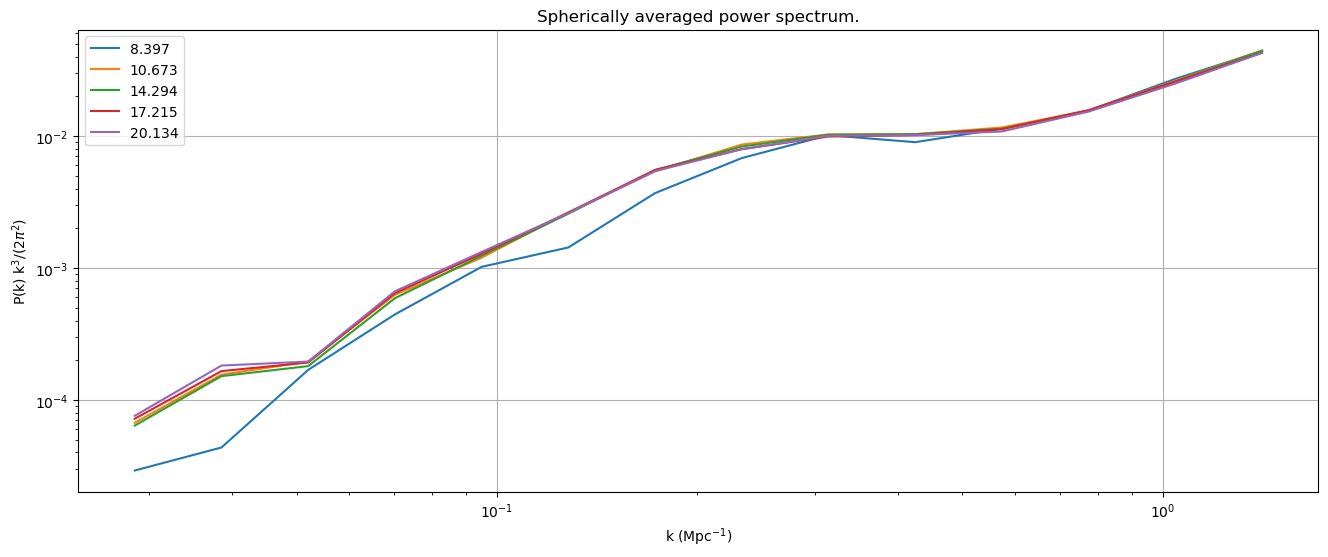

In [32]:
_ = SignalPlotting.power_spectrum([su for (sp, su) in images_21])


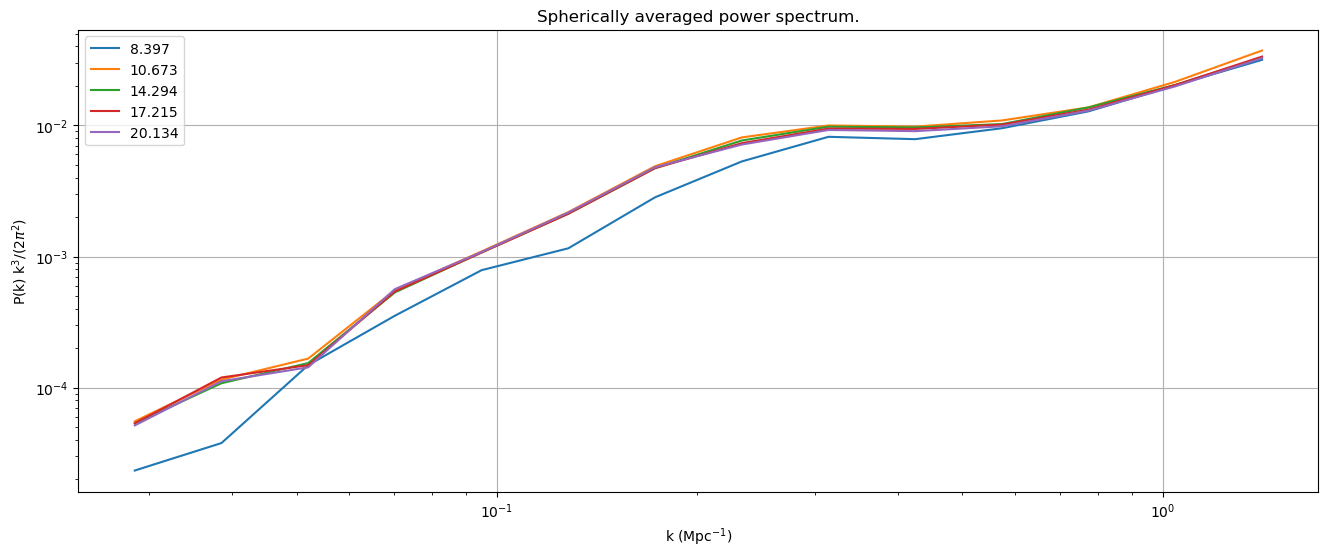

In [33]:
_ = SignalPlotting.power_spectrum([su for (sp, su) in images_combined])


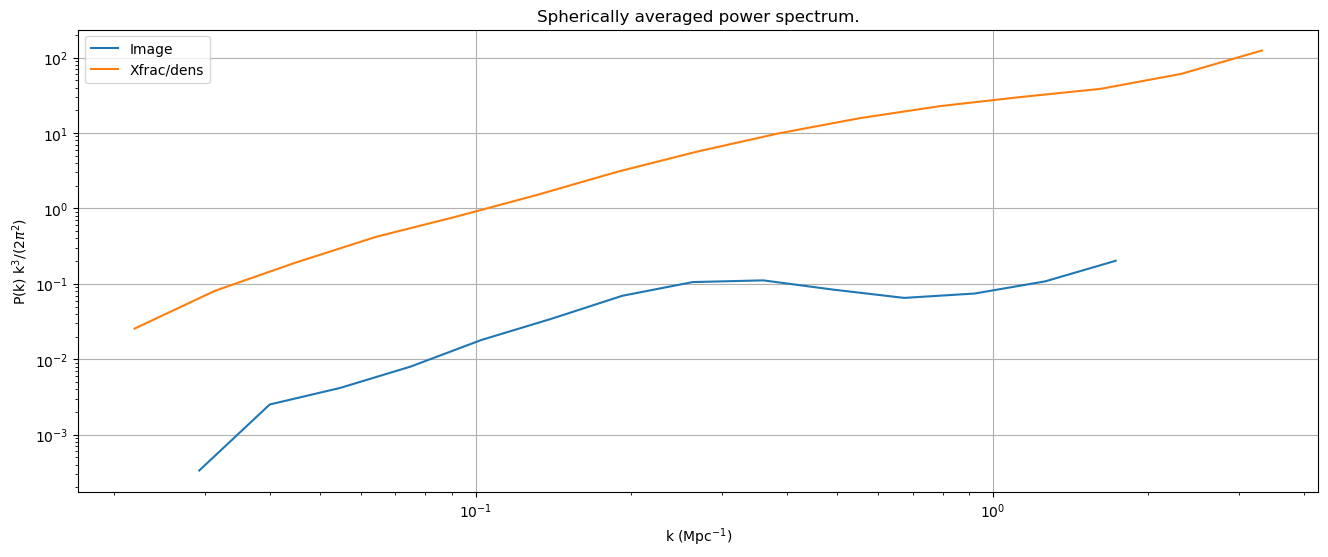

In [34]:
_ = SignalPlotting.power_spectrum_image_vs_xfrac_dens(
    images_combined[0][1],
    xfrac_dens_files[0],
)
